# KNN模型
## 分类问题
使用knowledge数据集，来自UCI主页，数据集一共包含403个观测和6个变量

### 构建数据集

In [9]:
# 导入第三方包
import pandas as pd
%config ZMQInteractiveShell.ast_node_interactivity='all'   # nootbook使用

# 导入数据
Knowledge = pd.read_excel(r'Knowledge.xlsx')
# 返回前5行数据
Knowledge.head()
Knowledge.info()
Knowledge['UNS'].value_counts()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,Very Low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 6 columns):
STG    403 non-null float64
SCG    403 non-null float64
STR    403 non-null float64
LPR    403 non-null float64
PEG    403 non-null float64
UNS    403 non-null object
dtypes: float64(5), object(1)
memory usage: 19.0+ KB


Low         129
Middle      122
High        102
Very Low     50
Name: UNS, dtype: int64

行代表学生，前5列已做了归一化处理。最后一列有4个不同的值

In [6]:
# 构造训练集和测试集
# 导入第三方模块
from sklearn import model_selection
# 将数据集拆分为训练集和测试集
predictors = Knowledge.columns[:-1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(Knowledge[predictors], 
                                                                    Knowledge.UNS, 
                                                                    test_size = 0.25, 
                                                                    random_state = 1234)

### 构建KNN
KNN模型容易受到k的影响，需要利用多重交叉验证的方法，获取理想的k值。

In [5]:
np.ceil(np.log2(Knowledge.shape[0]))

9.0

Text(6.0, 0.894162859526458, '最佳k值为6')

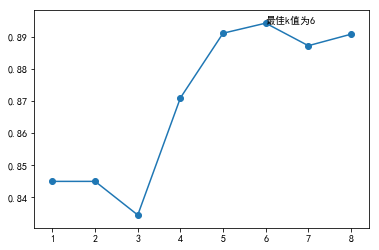

In [17]:
# 导入第三方模块
import numpy as np
from sklearn import neighbors
import matplotlib.pyplot as plt

# 设置待测试的不同k值
K = np.arange(1,np.ceil(np.log2(Knowledge.shape[0])))
# 构建空的列表，用于存储平均准确率
accuracy = []
for k in K:
    # 使用10重交叉验证的方法，对比每一个k值下KNN模型的预测准确率
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsClassifier(n_neighbors = int(k), 
                                                                               weights = 'distance'),
                                                X_train,
                                                y_train,
                                                cv = 10, 
                                                scoring='accuracy')
    accuracy.append(cv_result.mean())

# 从k个平均准确率中挑选出最大值所对应的下标    
arg_max = np.array(accuracy).argmax()

# 中文和负号的正常显示
plt.rcParams['font.sans-serif']=['SimHei']     # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False       # 用来正常显示负号
# 绘制不同K值与平均预测准确率之间的折线图
plt.plot(K, accuracy)
# 添加点图
plt.scatter(K, accuracy)
# 添加文字说明
plt.text(K[arg_max], accuracy[arg_max], '最佳k值为%s' %int(K[arg_max]))
# 显示图形
plt.show()

接下来，用这个最佳的k值，6，进行建模

In [19]:
# 导入第三方模块
from sklearn import metrics

# 重新构建模型，并将最佳的近邻个数设置为6
knn_class = neighbors.KNeighborsClassifier(n_neighbors = 6, weights = 'distance')
# 模型拟合
knn_class.fit(X_train, y_train)
# 模型在测试数据集上的预测
predict = knn_class.predict(X_test)
# 构建混淆矩阵
cm = pd.crosstab(y_test,predict) # 先实际再预测，对应：行是实际，列是预测
cm

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')

col_0,High,Low,Middle,Very Low
UNS,,,,
High,29,0,1,0
Low,0,34,0,0
Middle,0,3,23,0
Very Low,0,5,0,6


Text(0.5, 17.0, ' Predict Lable')

Text(35.0, 0.5, ' Real Lable')

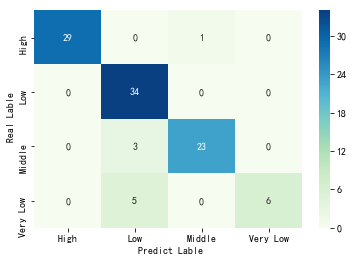

In [22]:
# 导入第三方模块
import seaborn as sns

# 将混淆矩阵构造成数据框，并加上字段名和行名称，用于行或列的含义说明
cm = pd.DataFrame(cm)
# 绘制热力图
sns.heatmap(cm, annot = True,cmap = 'GnBu')
# 添加x轴和y轴的标签
plt.xlabel(' Predict Lable')
plt.ylabel(' Real Lable')
# 图形显示
plt.show()

### 模型预测和评估

In [23]:
# 模型整体的预测准确率
metrics.scorer.accuracy_score(y_test, predict)
# 准确率计算公式：主对角线数字之和与所有数字之和。

0.9108910891089109

In [24]:
# 分类模型的评估报告
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

        High       1.00      0.97      0.98        30
         Low       0.81      1.00      0.89        34
      Middle       0.96      0.88      0.92        26
    Very Low       1.00      0.55      0.71        11

   micro avg       0.91      0.91      0.91       101
   macro avg       0.94      0.85      0.88       101
weighted avg       0.93      0.91      0.91       101



前四行代表因变量y中的各个类别值。
第一列precision表示模型的预测精度，“预测正确的类别个数/该类别预测的所有个数”；
第二列表示模型的预测覆盖率，“预测正确的类别个数/该类别实际的所有个数”；
第三列是对precision和recall的加权结果
第四列是类别实际的样本个数

## 预测问题
数据集：CCPP
来自UCI网站

In [26]:
# 读入数据
ccpp = pd.read_excel(r'CCPP.xlsx')
ccpp.head()
ccpp.info()
# 返回数据集的行数与列数
ccpp.shape

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


(9568, 5)

前四个变量是自变量，最后一列是连续型的因变量，由于4个自变量的量纲不一致，进行预测之前，做标准化

In [28]:
# 导入第三方包
from sklearn.preprocessing import minmax_scale
# 对所有自变量数据作标准化处理
predictors = ccpp.columns[:-1]
X = minmax_scale(ccpp[predictors])

In [29]:
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    ccpp.PE, 
                                                                    test_size = 0.25,
                                                                    random_state = 1234)

Text(7.0, 14.345159367748613, '最佳k值为7')

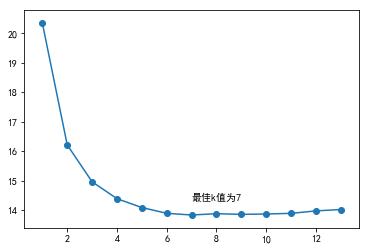

In [30]:
# 设置待测试的不同k值
K = np.arange(1,np.ceil(np.log2(ccpp.shape[0])))
# 构建空的列表，用于存储平均MSE
mse = []
for k in K:
    # 使用10重交叉验证的方法，比对每一个k值下KNN模型的计算MSE
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsRegressor(n_neighbors = int(k), weights = 'distance'), 
                                                X_train, 
                                                y_train, 
                                                cv = 10, 
                                                scoring='neg_mean_squared_error')
    mse.append((-1*cv_result).mean())

# 从k个平均MSE中挑选出最小值所对应的下标  
arg_min = np.array(mse).argmin()
# 绘制不同K值与平均MSE之间的折线图
plt.plot(K, mse)
# 添加点图
plt.scatter(K, mse)
# 添加文字说明
plt.text(K[arg_min], mse[arg_min] + 0.5, '最佳k值为%s' %int(K[arg_min]))
# 显示图形
plt.show()

In [31]:
# 重新构建模型，并将最佳的近邻个数设置为7
knn_reg = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'distance')
# 模型拟合
knn_reg.fit(X_train, y_train)
# 模型在测试集上的预测
predict = knn_reg.predict(X_test)
# 计算MSE值
metrics.mean_squared_error(y_test, predict)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='distance')

12.814094947334919

In [32]:
# 对比真实值和实际值
pd.DataFrame({'Real':y_test,'Predict':predict}, columns=['Real','Predict']).head(10)

,Real,Predict
2620,435.68,437.677598
6998,442.90,443.101594
2857,449.01,448.758681
6510,449.75,445.560046
5368,455.20,453.010541
3486,453.49,455.462162
6251,479.14,476.543251
5548,446.71,445.576955
2266,429.80,430.824836
5615,474.40,474.400000


KNN算法和决策树非常类似，不妨对比下两个模型在CCPP两个数据集上的表现

In [33]:
# 导入第三方模块
from sklearn import tree

# 预设各参数的不同选项值
max_depth = [19,21,23,25,27]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]
parameters = {'max_depth':max_depth, 
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}
# 网格搜索法，测试不同的参数值
grid_dtreg = model_selection.GridSearchCV(estimator = tree.DecisionTreeRegressor(), 
                                          param_grid = parameters, 
                                          cv=10)
# 模型拟合
grid_dtreg.fit(X_train, y_train)
# 返回最佳组合的参数值
grid_dtreg.best_params_

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [19, 21, 23, 25, 27], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [2, 4, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'max_depth': 21, 'min_samples_leaf': 10, 'min_samples_split': 4}

In [34]:
# 构建用于回归的决策树
CART_Reg = tree.DecisionTreeRegressor(max_depth = 21, min_samples_leaf = 10, min_samples_split = 6)
# 回归树拟合
CART_Reg.fit(X_train, y_train)
# 模型在测试集上的预测
pred = CART_Reg.predict(X_test)
# 计算衡量模型好坏的MSE值
metrics.mean_squared_error(y_test, pred)

DecisionTreeRegressor(criterion='mse', max_depth=21, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

16.17598770280405

对于该CCPP数据集，决策树模型的mse>KNN模型的mse。